In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
from sklearn import metrics

# Creation of the data set

Real world data

Data source: Temp.csv

# One to one prediction

V1 column for 1 to 1 prediction. Shape: (1625,)



In [2]:
d1=pd.read_csv("Temp.csv")
data=np.array(d1.V1)

# Data preparation

Arguments:

-time_wind: length of the sequence of the historical data;

-output: how many steps ahead prediction is going to be performed;

-nb_var: number of variables of the data set;

Output:

-x_batches: input for the training set. Size: (1518, 2, 1);

-y_batches: output for the training set. Size: (1518, 1);

-x_test: inputs for the test set; Size: (102, 2, 1);

-y_test: output for the test set; Size: (102, 1);

! Note, the size of the first dimension will vary depending on the size of the time_wind. The second dimension refers to the time_wind size, thisrd dimension: number of variables;

In [10]:
def data_preparation(data,time_wind=2,output=1,nb_var=1,batch_size=1):
    data_train=data[:1520]
    x_train=[]
    for i in range((len(data_train)-1)-(time_wind-1)):
        x_train.append(data_train[i:(i+time_wind)])
    x_train=np.array(x_train)
    x_batches=(x_train[:(len(x_train)-(len(x_train)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_train=data_train[time_wind:len(data_train)]
    y_batches=(y_train[:(len(y_train)-(len(y_train)%batch_size))]).reshape(-1,output)
    data_test=data[1521:]
    x_t=[]
    for i in range((len(data_test)-1)-(time_wind-1)):
        x_t.append(data_test[i:(i+time_wind)])
    x_t=np.array(x_t)
    x_test=(x_t[:(len(x_t)-(len(x_t)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_t=data_test[time_wind:len(data_test)]
    y_test=(y_t[:(len(y_t)-(len(y_t)%batch_size))]).reshape(-1,output)
    return x_batches, y_batches, x_test, y_test

# TensorFlow computation graph

Arguments:

-epochs: how many times the network is going to be trained;

-time_wind: the length of the historical sequence;

-hidden: number of hidden layers;

-nb_var: amount of input variables;

-output: how many steps ahead prediction is going to be performed;

-lr: learning rate.

Outputs:

-mse_test: the mean squared error for the final prediction vector;

-y_pred: the vector of predictions.


In [13]:
def run_graph(epochs,time_wind,hidden=10,nb_var=1,output=1,lr=0.01,r_s=1):

    from tensorflow.contrib import rnn
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,time_wind,nb_var])
    Y=tf.placeholder(tf.float32,[None,output])
 
    tf.set_random_seed(r_s)
    x=tf.unstack(X,time_wind,1)
    
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden)
    rnn_output, states=rnn.static_rnn(basic_cell,x,dtype=tf.float32)

    stacked_rnn_output=tf.reshape(rnn_output[-1],[-1,hidden])
    stacked_outputs=tf.layers.dense(stacked_rnn_output,output)
    loss=tf.reduce_mean(tf.squared_difference(stacked_outputs, Y))
    optimizer=tf.train.AdamOptimizer(learning_rate=lr)
    training_op=optimizer.minimize(loss)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            sess.run(training_op,feed_dict={X: x_batches, Y: y_batches})
            if ep % 100 == 0:
                mse=loss.eval(feed_dict={X: x_batches, Y: y_batches})
                print(ep,"\tMSE:",mse)
        y_pred=sess.run(stacked_outputs,feed_dict={X:x_test})
        mse_test=loss.eval(feed_dict={X:x_test,Y:y_test})
        print(mse)
        print(mse_test)
    sess.close() 
    return mse_test, y_pred

# Visualisation

In [16]:
def visualisation():
    plt.plot(y_test,label='Actual')
    plt.plot(y_pred,label='Forecast')
    plt.legend(loc="upper left")
    return plt.show

# Experiments

## Naive models
### Average naive model

In [20]:
x_batches, y_batches, x_test, y_test=data_preparation(data,1)
print(metrics.mean_squared_error(x_batches[:,0],np.full(len(x_batches),np.mean(x_batches))))

47.9805617233


### Constant naive models

In [21]:
x_t1=y_test[:102]
x_t=y_test[1:]
print(metrics.mean_squared_error(x_t,x_t1))

17.3819717059


# Time_wind
The aim of the first  experiment is to define the optimal size of the time_wind

0 	MSE: 89.2851
100 	MSE: 18.9029
200 	MSE: 15.83
300 	MSE: 15.4518
400 	MSE: 15.2782
500 	MSE: 15.5626
600 	MSE: 15.5673
700 	MSE: 15.2676
800 	MSE: 15.1893
900 	MSE: 15.1557
15.1557
15.6058
0 	MSE: 95.8625
100 	MSE: 20.1732
200 	MSE: 16.1226
300 	MSE: 15.5844
400 	MSE: 15.3195
500 	MSE: 15.2281
600 	MSE: 15.1957
700 	MSE: 15.3325
800 	MSE: 15.175
900 	MSE: 15.1539
15.1539
15.5436
0 	MSE: 77.5217
100 	MSE: 17.0689
200 	MSE: 15.563
300 	MSE: 15.4848
400 	MSE: 15.2325
500 	MSE: 15.1782
600 	MSE: 15.1722
700 	MSE: 15.1425
800 	MSE: 15.1991
900 	MSE: 15.3597
15.3597
15.7371
0 	MSE: 95.1276
100 	MSE: 19.2887
200 	MSE: 15.9173
300 	MSE: 15.4141
400 	MSE: 15.3398
500 	MSE: 15.2292
600 	MSE: 15.1802
700 	MSE: 15.154
800 	MSE: 15.1442
900 	MSE: 15.1366
15.1366
15.5266
0 	MSE: 66.4771
100 	MSE: 16.2452
200 	MSE: 15.4746
300 	MSE: 15.3351
400 	MSE: 15.2756
500 	MSE: 15.1713
600 	MSE: 15.1556
700 	MSE: 15.1779
800 	MSE: 15.1382
900 	MSE: 15.1267
15.1267
15.7303
0 	MSE: 67.2958
100 	MSE: 16.2981
2

<function matplotlib.pyplot.show>

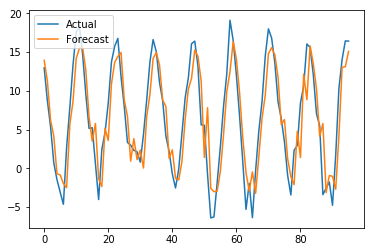

In [22]:
mse_mean=[]
mse_var=[]
for j in range(1,9,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,j)
        mse_test,y_pred=run_graph(1000,j,hidden=1,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with time_wind={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with time_wind={} equals{}".format(j, np.var(mse)))
visualisation()

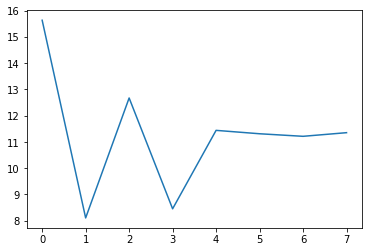

In [23]:
plt.plot(mse_mean)

Summary: the highest accuracy was achieved with time_wind=2. Then MSE=8.106884. 
The accuracy of the basic model with time_wind=1 is equal to 15.629408, what is better the the results of the naive model.

# Hidden layers
The aim of the second experiment is to discover wether the increment of the number of hidden layers will improve the accuracy

0 	MSE: 64.1269
100 	MSE: 9.48087
200 	MSE: 8.01387
300 	MSE: 7.63837
400 	MSE: 7.54351
500 	MSE: 7.41392
600 	MSE: 7.39054
700 	MSE: 7.38457
800 	MSE: 7.40716
900 	MSE: 7.32247
7.32247
8.06202
0 	MSE: 79.2218
100 	MSE: 10.6444
200 	MSE: 8.23657
300 	MSE: 7.73942
400 	MSE: 7.55922
500 	MSE: 7.44509
600 	MSE: 7.41283
700 	MSE: 7.35935
800 	MSE: 7.3446
900 	MSE: 7.43265
7.43265
8.04322
0 	MSE: 77.4605
100 	MSE: 10.4459
200 	MSE: 8.20017
300 	MSE: 7.71763
400 	MSE: 7.52772
500 	MSE: 7.47975
600 	MSE: 7.41571
700 	MSE: 7.38824
800 	MSE: 7.34538
900 	MSE: 7.33005
7.33005
8.07315
0 	MSE: 69.1762
100 	MSE: 9.79153
200 	MSE: 8.10459
300 	MSE: 7.67293
400 	MSE: 7.53632
500 	MSE: 7.45051
600 	MSE: 7.43521
700 	MSE: 7.42693
800 	MSE: 7.35141
900 	MSE: 7.33125
7.33125
8.23783
0 	MSE: 74.6565
100 	MSE: 10.1345
200 	MSE: 8.15907
300 	MSE: 7.69548
400 	MSE: 7.54068
500 	MSE: 7.4415
600 	MSE: 7.39137
700 	MSE: 7.43586
800 	MSE: 7.3483
900 	MSE: 7.3447
7.3447
8.03687
0 	MSE: 79.5694
100 	MSE: 10.5582
2

<function matplotlib.pyplot.show>

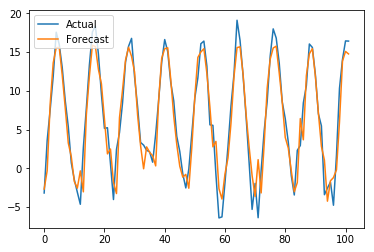

In [26]:
mse_mean=[]
mse_var=[]
for j in range(1,11,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(1000,2,hidden=j,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with hidden={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with hidden={} equals{}".format(j, np.var(mse)))
visualisation()
    

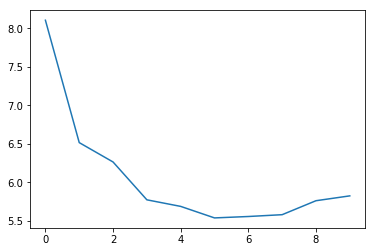

In [27]:
plt.plot(mse_mean)

Summary: The lowest MSE is achieved with hidden=6. MSE=5.53754. 
The structure of the data is too complex to hadle it with the smaller size of hidden states, however, the bigger amount of hiddent units cause overfitting.

# Optimisation of the training time

## Learning rate: 0.1

0 	MSE: 45.2914
100 	MSE: 5.77713
200 	MSE: 5.53157
300 	MSE: 5.45307
400 	MSE: 5.39992
500 	MSE: 5.35925
600 	MSE: 5.30422
700 	MSE: 5.26022
800 	MSE: 5.2584
900 	MSE: 5.26384
5.26384
5.60561
0 	MSE: 65.872
100 	MSE: 5.8811
200 	MSE: 5.83239
300 	MSE: 5.61661
400 	MSE: 5.5689
500 	MSE: 5.55324
600 	MSE: 5.54533
700 	MSE: 5.54409
800 	MSE: 5.52529
900 	MSE: 5.49831
5.49831
5.54414
0 	MSE: 84.0618
100 	MSE: 6.08104
200 	MSE: 5.64223
300 	MSE: 5.57562
400 	MSE: 5.54547
500 	MSE: 5.50997
600 	MSE: 5.50479
700 	MSE: 5.42837
800 	MSE: 5.39336
900 	MSE: 5.37262
5.37262
5.90583
0 	MSE: 46.8217
100 	MSE: 6.09745
200 	MSE: 5.79861
300 	MSE: 5.69504
400 	MSE: 5.63168
500 	MSE: 5.60402
600 	MSE: 5.56629
700 	MSE: 5.58711
800 	MSE: 5.52254
900 	MSE: 5.50682
5.50682
5.64822
0 	MSE: 75.2768
100 	MSE: 6.11523
200 	MSE: 5.77325
300 	MSE: 5.59531
400 	MSE: 5.53648
500 	MSE: 5.48814
600 	MSE: 5.45051
700 	MSE: 5.43599
800 	MSE: 5.39876
900 	MSE: 5.38122
5.38122
5.56935
0 	MSE: 68.2484
100 	MSE: 5.84738


<function matplotlib.pyplot.show>

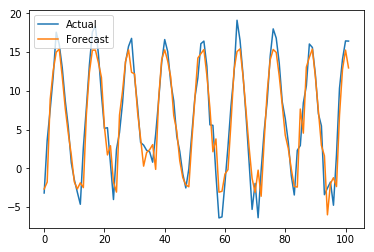

In [29]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=6,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

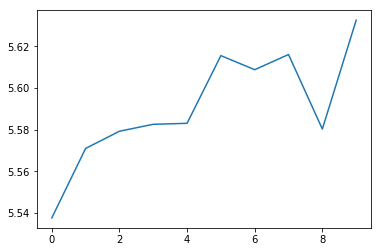

In [30]:
plt.plot(mse_mean)

Summary:
With the learning rate equal to 0.01, increasing of the training time does not improve the quality of predictions.

## Learning rate: 0.01


0 	MSE: 52.883
100 	MSE: 16.3837
200 	MSE: 8.19915
300 	MSE: 6.38131
400 	MSE: 5.86621
500 	MSE: 5.64632
600 	MSE: 5.53691
700 	MSE: 5.49246
800 	MSE: 5.46891
900 	MSE: 5.45214
1000 	MSE: 5.43731
1100 	MSE: 5.42159
1200 	MSE: 5.40389
1300 	MSE: 5.38524
1400 	MSE: 5.36775
1500 	MSE: 5.35598
1600 	MSE: 5.34662
1700 	MSE: 5.3387
1800 	MSE: 5.33319
1900 	MSE: 5.32542
5.32542
5.27869
0 	MSE: 77.5163
100 	MSE: 21.9309
200 	MSE: 10.2758
300 	MSE: 7.15848
400 	MSE: 6.20794
500 	MSE: 5.84449
600 	MSE: 5.67382
700 	MSE: 5.58564
800 	MSE: 5.52808
900 	MSE: 5.49114
1000 	MSE: 5.46306
1100 	MSE: 5.43976
1200 	MSE: 5.4195
1300 	MSE: 5.40141
1400 	MSE: 5.38474
1500 	MSE: 5.3685
1600 	MSE: 5.35212
1700 	MSE: 5.33685
1800 	MSE: 5.32429
1900 	MSE: 5.31429
5.31429
5.68937
0 	MSE: 100.859
100 	MSE: 25.9924
200 	MSE: 12.2627
300 	MSE: 7.82938
400 	MSE: 6.52269
500 	MSE: 6.16317
600 	MSE: 6.03875
700 	MSE: 5.96991
800 	MSE: 5.92021
900 	MSE: 5.87483
1000 	MSE: 5.8222
1100 	MSE: 5.77587
1200 	MSE: 5.74852
13

<function matplotlib.pyplot.show>

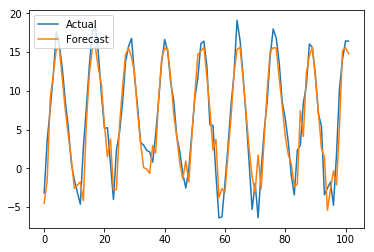

In [31]:
mse_mean=[]
mse_var=[]
for j in range(2000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=6,lr=0.01,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

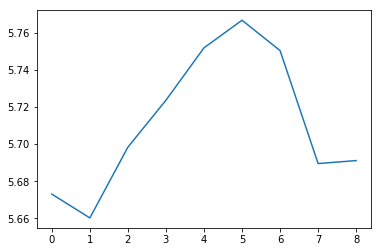

In [32]:
plt.plot(mse_mean)

Summary:  With learning rate equal to 0.01, the highest accuracy was achieved with number of training epochs equal to 3000. Then, MSE=5.66024

## Learning rate: 0.001

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(4000,17000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=6,lr=0.001,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

0 	MSE: 54.1166
100 	MSE: 45.4235
200 	MSE: 39.8416
300 	MSE: 35.2431
400 	MSE: 31.4146
500 	MSE: 28.142
600 	MSE: 25.299
700 	MSE: 22.8131
800 	MSE: 20.6328
900 	MSE: 18.7212
1000 	MSE: 17.0329
1100 	MSE: 15.5077
1200 	MSE: 14.166
1300 	MSE: 12.9858
1400 	MSE: 11.947
1500 	MSE: 11.0385
1600 	MSE: 10.25
1700 	MSE: 9.56997
1800 	MSE: 8.98609
1900 	MSE: 8.48593
2000 	MSE: 8.05812
2100 	MSE: 7.69336
2200 	MSE: 7.38381
2300 	MSE: 7.12188
2400 	MSE: 6.89992
2500 	MSE: 6.71084
2600 	MSE: 6.54861
2700 	MSE: 6.40865
2800 	MSE: 6.28825
2900 	MSE: 6.18568
3000 	MSE: 6.098
3100 	MSE: 6.02214
3200 	MSE: 5.95592
3300 	MSE: 5.89773
3400 	MSE: 5.8461
3500 	MSE: 5.79965
3600 	MSE: 5.75717
3700 	MSE: 5.71783
3800 	MSE: 5.68153
3900 	MSE: 5.6488
5.6488
5.63337
0 	MSE: 78.5888
100 	MSE: 63.2078
200 	MSE: 51.2814
300 	MSE: 45.7973
400 	MSE: 41.0561
500 	MSE: 36.8476
600 	MSE: 33.0853
700 	MSE: 29.7738
800 	MSE: 26.8488
900 	MSE: 24.2647
1000 	MSE: 21.966
1100 	MSE: 19.9112
1200 	MSE: 18.0878
1300 	MSE: 16

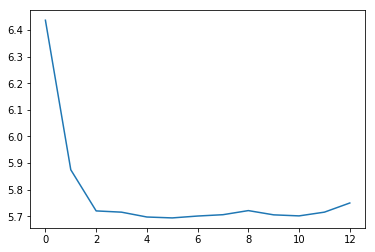

In [37]:
plt.plot(mse_mean)

Summary: with the learnig rate equal to 0.001, the lowes MSE was achieved with number of epoch equal to 9000. MSE=5.69389

 # Many to one prediction

V1, V2 columns for 2 to 1 prediction. Shape: (2,1625)

In [40]:
data2=np.array([d1.V1,d1.V2])

# Data preparation

In [39]:
def data_preparation2(data,time_wind=2,output=1,nb_var=2,batch_size=1):
    data_train=data[:1520]
    x_train=[]
    for i in range((len(data_train)-1)-(time_wind-1)):
        x_train.append(data_train[i:(i+time_wind)])
    x_train=np.array(x_train)
    x_batches=(x_train[:(len(x_train)-(len(x_train)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_train=data_train[time_wind:len(data_train)]
    y_batches=(y_train[:,0][:(len(y_train)-(len(y_train)%batch_size))]).reshape(-1,output)
    data_test=data[1521:]
    x_t=[]
    for i in range((len(data_test)-1)-(time_wind-1)):
        x_t.append(data_test[i:(i+time_wind)])
    x_t=np.array(x_t)
    x_test=(x_t[:(len(x_t)-(len(x_t)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_t=data_test[time_wind:len(data_test)]
    y_test=(y_t[:,0][:(len(y_t)-(len(y_t)%batch_size))]).reshape(-1,output)
    return x_batches, y_batches, x_test, y_test

# Time_wind

0 	MSE: 88.5836
100 	MSE: 24.0857
200 	MSE: 13.9026
300 	MSE: 12.9125
400 	MSE: 11.8796
500 	MSE: 12.4738
600 	MSE: 11.8089
700 	MSE: 20.2026
800 	MSE: 12.6024
900 	MSE: 11.935
11.935
10.9429
0 	MSE: 94.8671
100 	MSE: 26.7605
200 	MSE: 14.2902
300 	MSE: 13.3051
400 	MSE: 12.0578
500 	MSE: 13.4696
600 	MSE: 12.1738
700 	MSE: 11.6602
800 	MSE: 20.1506
900 	MSE: 12.7524
12.7524
11.4038
0 	MSE: 85.8878
100 	MSE: 14.7821
200 	MSE: 12.753
300 	MSE: 11.8683
400 	MSE: 11.906
500 	MSE: 11.5856
600 	MSE: 13.2188
700 	MSE: 21.2403
800 	MSE: 13.1617
900 	MSE: 12.3419
12.3419
11.1729
0 	MSE: 93.4602
100 	MSE: 20.3895
200 	MSE: 18.3122
300 	MSE: 12.1307
400 	MSE: 20.1048
500 	MSE: 12.0217
600 	MSE: 11.6318
700 	MSE: 18.3826
800 	MSE: 12.2967
900 	MSE: 11.7893
11.7893
10.8963
0 	MSE: 85.8474
100 	MSE: 14.7022
200 	MSE: 18.8643
300 	MSE: 12.3
400 	MSE: 11.7611
500 	MSE: 12.0866
600 	MSE: 11.65
700 	MSE: 28.373
800 	MSE: 19.0105
900 	MSE: 13.0112
13.0112
11.7309
0 	MSE: 67.2704
100 	MSE: 12.5022
200 	M

<function matplotlib.pyplot.show>

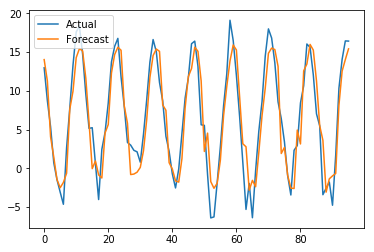

In [42]:
mse_mean=[]
mse_var=[]
for j in range(1,9,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation2(data2.T,j,nb_var=2)
        mse_test,y_pred=run_graph(1000,j,hidden=1,lr=0.1,r_s=i,nb_var=2)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with time_wind={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with time_wind={} equals{}".format(j, np.var(mse)))
visualisation()

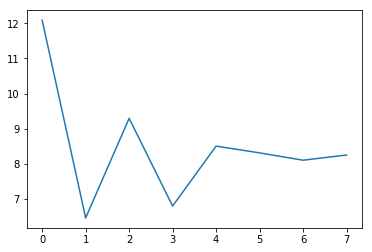

In [43]:
plt.plot(mse_mean)

Summary: The lowest MSE was achieved with the time window of size 2 (time_wind=2). MSE=6.4604

# Hidden layers

0 	MSE: 65.8478
100 	MSE: 9.75538
200 	MSE: 6.51682
300 	MSE: 6.23264
400 	MSE: 6.03737
500 	MSE: 5.42147
600 	MSE: 5.81051
700 	MSE: 5.26509
800 	MSE: 5.50756
900 	MSE: 5.40846
5.40846
6.26858
0 	MSE: 79.1796
100 	MSE: 9.24734
200 	MSE: 7.27696
300 	MSE: 6.35245
400 	MSE: 5.97109
500 	MSE: 5.55446
600 	MSE: 5.53085
700 	MSE: 5.38062
800 	MSE: 5.65682
900 	MSE: 5.6811
5.6811
6.26903
0 	MSE: 81.8529
100 	MSE: 10.5493
200 	MSE: 7.20912
300 	MSE: 6.54359
400 	MSE: 6.80592
500 	MSE: 5.56135
600 	MSE: 5.45851
700 	MSE: 5.79102
800 	MSE: 5.93825
900 	MSE: 5.64113
5.64113
6.59518
0 	MSE: 69.1249
100 	MSE: 11.2484
200 	MSE: 6.63711
300 	MSE: 5.9939
400 	MSE: 5.8123
500 	MSE: 5.77415
600 	MSE: 5.47125
700 	MSE: 5.83335
800 	MSE: 5.43852
900 	MSE: 5.21501
5.21501
6.64756
0 	MSE: 77.7404
100 	MSE: 8.95577
200 	MSE: 6.71343
300 	MSE: 6.08159
400 	MSE: 6.09902
500 	MSE: 5.51862
600 	MSE: 5.64824
700 	MSE: 5.62928
800 	MSE: 5.55715
900 	MSE: 5.22315
5.22315
6.58264
0 	MSE: 79.5822
100 	MSE: 9.03399


<function matplotlib.pyplot.show>

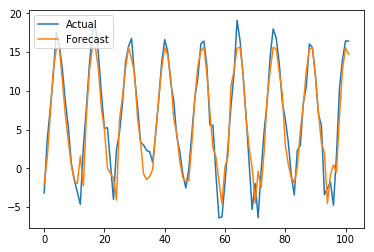

In [45]:
mse_mean=[]
mse_var=[]
for j in range(1,11,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation2(data2.T,2,nb_var=2)
        mse_test,y_pred=run_graph(1000,2,hidden=j,lr=0.1,r_s=i,nb_var=2)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with hidden={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with hidden={} equals{}".format(j, np.var(mse)))
visualisation()

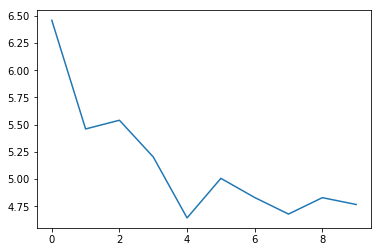

In [46]:
plt.plot(mse_mean)

Summary: the highest accuracy was achieved with the hidden state size equal to hidden=5. MSE=4.64192

# Optimisation of the training time

## Learning rate: 0.1

0 	MSE: 87.3344
100 	MSE: 4.92164
200 	MSE: 4.386
300 	MSE: 4.2422
400 	MSE: 4.28982
500 	MSE: 4.15645
600 	MSE: 4.10701
700 	MSE: 4.09002
800 	MSE: 4.21483
900 	MSE: 4.15413
4.15413
5.36944
0 	MSE: 68.9637
100 	MSE: 4.67278
200 	MSE: 4.39652
300 	MSE: 4.2942
400 	MSE: 4.28413
500 	MSE: 4.26551
600 	MSE: 4.26243
700 	MSE: 4.26277
800 	MSE: 4.25786
900 	MSE: 4.25542
4.25542
5.27641
0 	MSE: 60.9873
100 	MSE: 4.37676
200 	MSE: 4.25457
300 	MSE: 4.22383
400 	MSE: 4.21873
500 	MSE: 4.20069
600 	MSE: 4.30795
700 	MSE: 4.18301
800 	MSE: 4.19306
900 	MSE: 4.16166
4.16166
4.70787
0 	MSE: 57.1906
100 	MSE: 4.51716
200 	MSE: 4.21933
300 	MSE: 4.21315
400 	MSE: 4.20506
500 	MSE: 4.17376
600 	MSE: 4.20205
700 	MSE: 4.44344
800 	MSE: 4.11349
900 	MSE: 4.333
4.333
4.70348
0 	MSE: 67.6853
100 	MSE: 5.60661
200 	MSE: 4.33305
300 	MSE: 4.29507
400 	MSE: 4.26409
500 	MSE: 4.22998
600 	MSE: 4.21382
700 	MSE: 4.18945
800 	MSE: 4.18031
900 	MSE: 4.17534
4.17534
4.50492
0 	MSE: 93.9964
100 	MSE: 4.66363
200 

<function matplotlib.pyplot.show>

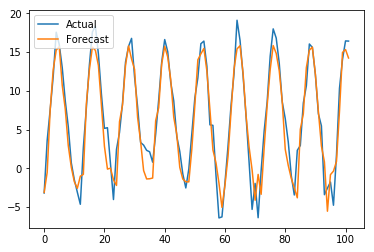

In [48]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation2(data2.T,2,nb_var=2)
        mse_test,y_pred=run_graph(j,2,hidden=5,lr=0.1,r_s=i,nb_var=2)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

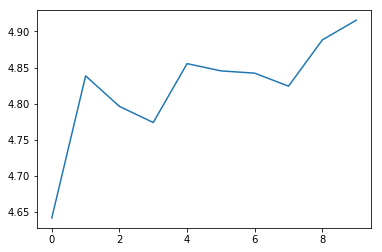

In [49]:
plt.plot(mse_mean)

Summary: with the learning rate equal to 0.1, the increment of the training time does not inprove the accuracy of the prediction.

## Learning rate: 0.01

0 	MSE: 99.1663
100 	MSE: 27.6477
200 	MSE: 13.206
300 	MSE: 7.91507
400 	MSE: 5.89984
500 	MSE: 5.12366
600 	MSE: 4.67009
700 	MSE: 4.42653
800 	MSE: 4.30649
900 	MSE: 4.26166
4.26166
4.87486
0 	MSE: 77.5026
100 	MSE: 28.3286
200 	MSE: 12.787
300 	MSE: 7.48968
400 	MSE: 5.68523
500 	MSE: 4.98034
600 	MSE: 4.67113
700 	MSE: 4.52343
800 	MSE: 4.44968
900 	MSE: 4.40041
4.40041
4.59207
0 	MSE: 67.8586
100 	MSE: 24.2585
200 	MSE: 10.8002
300 	MSE: 6.48122
400 	MSE: 5.23077
500 	MSE: 4.77573
600 	MSE: 4.50878
700 	MSE: 4.32145
800 	MSE: 4.24001
900 	MSE: 4.20542
4.20542
4.55487
0 	MSE: 62.5676
100 	MSE: 21.3556
200 	MSE: 9.73618
300 	MSE: 6.02783
400 	MSE: 4.98041
500 	MSE: 4.59325
600 	MSE: 4.42898
700 	MSE: 4.34256
800 	MSE: 4.30883
900 	MSE: 4.26715
4.26715
4.8158
0 	MSE: 86.4471
100 	MSE: 27.3889
200 	MSE: 12.1667
300 	MSE: 7.15099
400 	MSE: 5.53988
500 	MSE: 4.9913
600 	MSE: 4.70207
700 	MSE: 4.51531
800 	MSE: 4.39683
900 	MSE: 4.32437
4.32437
4.85733
0 	MSE: 103.223
100 	MSE: 35.295
2

<function matplotlib.pyplot.show>

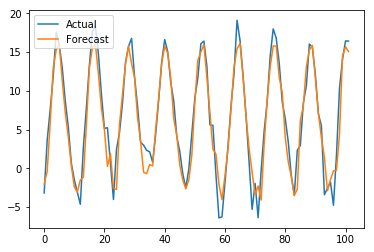

In [50]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation2(data2.T,2,nb_var=2)
        mse_test,y_pred=run_graph(j,2,hidden=5,lr=0.01,r_s=i,nb_var=2)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

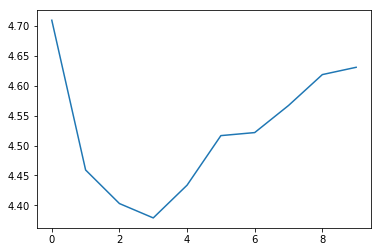

In [51]:
plt.plot(mse_mean)

Summary: With the learning rate equal to 0.01 the highest accuracy was achieved with number of epochs=4000. MSE=4.37898

## Learning rate: 0.001

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(4000,15000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation2(data2.T,2,nb_var=2)
        mse_test,y_pred=run_graph(j,2,hidden=5,lr=0.001,r_s=i,nb_var=2)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

0 	MSE: 100.581
100 	MSE: 73.5388
200 	MSE: 55.1399
300 	MSE: 49.2104
400 	MSE: 44.1475
500 	MSE: 39.5719
600 	MSE: 35.7207
700 	MSE: 32.4711
800 	MSE: 29.6867
900 	MSE: 27.2472
1000 	MSE: 25.0568
1100 	MSE: 23.0521
1200 	MSE: 21.1999
1300 	MSE: 19.4872
1400 	MSE: 17.9218
1500 	MSE: 16.5119
1600 	MSE: 15.2575
1700 	MSE: 14.1477
1800 	MSE: 13.1676
1900 	MSE: 12.3028
2000 	MSE: 11.5398
2100 	MSE: 10.8661
2200 	MSE: 10.2683
2300 	MSE: 9.72705
2400 	MSE: 9.21402
2500 	MSE: 8.70654
2600 	MSE: 8.21402
2700 	MSE: 7.75958
2800 	MSE: 7.34832
2900 	MSE: 6.97678
3000 	MSE: 6.64018
3100 	MSE: 6.33535
3200 	MSE: 6.06223
3300 	MSE: 5.82245
3400 	MSE: 5.61577
3500 	MSE: 5.43927
3600 	MSE: 5.28906
3700 	MSE: 5.16135
3800 	MSE: 5.05258
3900 	MSE: 4.95945
4.95945
5.94134
0 	MSE: 78.7617
100 	MSE: 67.3323
200 	MSE: 60.5985
300 	MSE: 54.9607
400 	MSE: 49.9523
500 	MSE: 45.313
600 	MSE: 41.1576
700 	MSE: 37.4886
800 	MSE: 34.1736
900 	MSE: 31.1577
1000 	MSE: 28.4019
1100 	MSE: 25.9037
1200 	MSE: 23.6525
13

In [ ]:
plt.plot(mse_mean)

Summary: with the learning rate 0.001, the highest accuracy is achieved with number of epochs=10000. MSE=4.38957